### Import libraries

In [2]:
import psycopg2
import json
import requests
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# URL of the JSON data
url = "https://think.cs.vt.edu/corgis/datasets/json/airlines/airlines.json"
response = requests.get(url)
if response.status_code == 200:
    # Get the JSON data from the response
    json_data = response.json()

# Write the json data 
with open('airlines.json','w') as json_file:
     json_file.write(response.text)

### Create connection and database

In [4]:
import psycopg2

#establishing the connection
conn = psycopg2.connect(
   database="postgres", 
   user='postgres',
   password='password', 
   host='127.0.0.1',
   port= '5432'
)
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Preparing query to create a database
sql = '''CREATE database mydb''';

#Creating a database
# cursor.execute(sql)
print("Database created successfully........")


Database created successfully........


In [ ]:
# query="""DROP DATABASE mydb"""
# cursor.execute(query)

### Creating tables  - airports, time and statistics.

In [4]:
airports_table="""CREATE TABLE IF NOT EXISTS airports (
    Code VARCHAR(3) PRIMARY KEY,
    Name VARCHAR(255)
);"""
# Creating the table
cursor.execute(airports_table)

In [5]:
time_table="""CREATE TABLE IF NOT EXISTS time (
    Label VARCHAR(10) PRIMARY KEY,
    Month INTEGER,
    Month_Name VARCHAR(20),
    Year INTEGER
);"""
# Creating the table
cursor.execute(time_table)

In [7]:
stats_table="""CREATE TABLE IF NOT EXISTS statistics (
   ID SERIAL PRIMARY KEY,
        Airport_Code VARCHAR(3) REFERENCES airports(Code),
        Time_Label VARCHAR(10) REFERENCES Time(Label),
        Delays_Carrier INT,
        Delays_Late_Aircraft INT,
        Delays_National_Aviation_System INT,
        Delays_Security INT,
        Delays_Weather INT,
        Carriers_Names TEXT,
        Carriers_Total INT,
        Flights_Cancelled INT,
        Flights_Delayed INT,
        Flights_Diverted INT,
        Flights_On_Time INT,
        Flights_Total INT,
        Minutes_Delayed_Carrier INT,
        Minutes_Delayed_Late_Aircraft INT,
        Minutes_Delayed_National_Aviation_System INT,
        Minutes_Delayed_Security INT,
        Minutes_Delayed_Weather INT,
        Minutes_Delayed_Total INT
);"""
# Creating the table
cursor.execute(stats_table)

### Insert data 

In [11]:
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch data from the URL")
        return None

# Function to insert data into PostgreSQL database
def insert_data(data):
    
    for entry in data:
        airport_data = (entry['Airport']['Code'], entry['Airport']['Name'])
        cursor.execute(""" INSERT INTO Airports (Code, Name)
        VALUES (%s, %s)
        ON CONFLICT DO NOTHING """, airport_data)
        
        time_data = (entry['Time']['Label'], entry['Time']['Month'], entry['Time']['Month Name'], entry['Time']['Year'])
        cursor.execute("""INSERT INTO Time (Label, Month, Month_Name, Year)
        VALUES (%s, %s, %s, %s)
        ON CONFLICT DO NOTHING""", time_data)

        statistics_data = ( entry['Airport']['Code'], entry['Time']['Label'],
        entry['Statistics']['# of Delays']['Carrier'], entry['Statistics']['# of Delays']['Late Aircraft'],
        entry['Statistics']['# of Delays']['National Aviation System'], entry['Statistics']['# of Delays']['Security'],
        entry['Statistics']['# of Delays']['Weather'],
        entry['Statistics']['Carriers']['Names'], entry['Statistics']['Carriers']['Total'],
        entry['Statistics']['Flights']['Cancelled'], entry['Statistics']['Flights']['Delayed'],
        entry['Statistics']['Flights']['Diverted'], entry['Statistics']['Flights']['On Time'], entry['Statistics']['Flights']['Total'],
        entry['Statistics']['Minutes Delayed']['Carrier'], entry['Statistics']['Minutes Delayed']['Late Aircraft'],
        entry['Statistics']['Minutes Delayed']['National Aviation System'], entry['Statistics']['Minutes Delayed']['Security'],
        entry['Statistics']['Minutes Delayed']['Weather'], entry['Statistics']['Minutes Delayed']['Total'] )
        
        cursor.execute("""INSERT INTO Statistics (
            Airport_Code, Time_Label,
            Delays_Carrier, Delays_Late_Aircraft, Delays_National_Aviation_System,
            Delays_Security, Delays_Weather,
            Carriers_Names, Carriers_Total,
            Flights_Cancelled, Flights_Delayed, Flights_Diverted, Flights_On_Time, Flights_Total,
            Minutes_Delayed_Carrier, Minutes_Delayed_Late_Aircraft, Minutes_Delayed_National_Aviation_System,
            Minutes_Delayed_Security, Minutes_Delayed_Weather, Minutes_Delayed_Total
        )
        VALUES ( %s, %s,%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""", statistics_data)
        conn.commit()

with open('airlines.json','r') as json_file:
    data = json.load(json_file)
insert_data(data)

### Queries

In [39]:
# Records of airports and codes
query1 = """SELECT * FROM airports"""
airport_df = pd.read_sql(query1,conn)
airport_df

,code,name
0,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,BOS,"Boston, MA: Logan International"
2,BWI,"Baltimore, MD: Baltimore/Washington Internatio..."
3,CLT,"Charlotte, NC: Charlotte Douglas International"
4,DCA,"Washington, DC: Ronald Reagan Washington National"
5,DEN,"Denver, CO: Denver International"
6,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
7,DTW,"Detroit, MI: Detroit Metro Wayne County"
8,EWR,"Newark, NJ: Newark Liberty International"
9,FLL,"Fort Lauderdale, FL: Fort Lauderdale-Hollywood..."


In [40]:
# Table containing recorded time periods of airline operations
query2 = """SELECT * FROM time"""
time_df = pd.read_sql(query2,conn)
time_df

,label,month,month_name,year
0,2003/06,6,June,2003
1,2003/07,7,July,2003
2,2003/08,8,August,2003
3,2003/09,9,September,2003
4,2003/10,10,October,2003
...,...,...,...,...
147,2015/09,9,September,2015
148,2015/10,10,October,2015
149,2015/11,11,November,2015
150,2015/12,12,December,2015


In [41]:
# Statistics table with no of delays, total on time flight etc of airlines
query3 = """SELECT * FROM statistics"""
stats_df = pd.read_sql(query3,conn)
stats_df

,id,airport_code,time_label,delays_carrier,delays_late_aircraft,delays_national_aviation_system,delays_security,delays_weather,carriers_names,carriers_total,...,flights_delayed,flights_diverted,flights_on_time,flights_total,minutes_delayed_carrier,minutes_delayed_late_aircraft,minutes_delayed_national_aviation_system,minutes_delayed_security,minutes_delayed_weather,minutes_delayed_total
0,1,ATL,2003/06,1009,1275,3217,17,328,"American Airlines Inc.,JetBlue Airways,Contine...",11,...,5843,27,23974,30060,61606,68335,118831,518,19474,268764
1,2,BOS,2003/06,374,495,685,3,66,"American Airlines Inc.,Alaska Airlines Inc.,Co...",14,...,1623,3,7875,9639,20319,28189,24400,99,4160,77167
2,3,BWI,2003/06,296,477,389,8,78,"American Airlines Inc.,Continental Air Lines I...",11,...,1245,15,6998,8287,13635,26810,17556,278,6201,64480
3,4,CLT,2003/06,300,472,735,2,54,"American Airlines Inc.,Continental Air Lines I...",11,...,1562,14,7021,8670,14763,23379,23804,127,3792,65865
4,5,DCA,2003/06,283,268,487,4,58,"American Airlines Inc.,Alaska Airlines Inc.,Co...",13,...,1100,18,5321,6513,13775,13712,20999,120,4141,52747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4403,4404,SAN,2016/01,280,397,171,2,20,"American Airlines Inc.,Alaska Airlines Inc.,Je...",11,...,871,18,5030,6016,15482,23023,6021,79,1601,46206
4404,4405,SEA,2016/01,357,513,351,2,50,"American Airlines Inc.,Alaska Airlines Inc.,Je...",10,...,1274,31,8330,9739,25461,32693,11466,73,4324,74017
4405,4406,SFO,2016/01,560,947,2194,2,119,"American Airlines Inc.,Alaska Airlines Inc.,Je...",10,...,3825,20,8912,13206,43641,72557,153416,66,8930,278610
4406,4407,SLC,2016/01,338,540,253,3,38,"American Airlines Inc.,Alaska Airlines Inc.,Je...",8,...,1175,14,7426,8699,32066,33682,8057,57,3116,76978


In [69]:
#Trends of total flights over specific time periods
q1="""SELECT time_label, SUM(Flights_Total) AS total_flights
FROM Statistics
GROUP BY Time_Label
ORDER BY Time_Label;
"""
cursor.execute(q1)
result = cursor.fetchall()
result

[('2003/06', 332340),
 ('2003/07', 346388),
 ('2003/08', 345719),
 ('2003/09', 327439),
 ('2003/10', 343776),
 ('2003/11', 330380),
 ('2003/12', 347064),
 ('2004/01', 354461),
 ('2004/02', 336519),
 ('2004/03', 365740),
 ('2004/04', 355243),
 ('2004/05', 362402),
 ('2004/06', 359670),
 ('2004/07', 375716),
 ('2004/08', 380756),
 ('2004/09', 356013),
 ('2004/10', 371918),
 ('2004/11', 356824),
 ('2004/12', 369473),
 ('2005/01', 360758),
 ('2005/02', 330722),
 ('2005/03', 375263),
 ('2005/04', 361676),
 ('2005/05', 375936),
 ('2005/06', 372888),
 ('2005/07', 385086),
 ('2005/08', 386114),
 ('2005/09', 353184),
 ('2005/10', 365676),
 ('2005/11', 349256),
 ('2005/12', 356963),
 ('2006/01', 362122),
 ('2006/02', 331902),
 ('2006/03', 378464),
 ('2006/04', 364055),
 ('2006/05', 374752),
 ('2006/06', 371444),
 ('2006/07', 384891),
 ('2006/08', 389345),
 ('2006/09', 362027),
 ('2006/10', 379383),
 ('2006/11', 363951),
 ('2006/12', 375616),
 ('2007/01', 380261),
 ('2007/02', 346604),
 ('2007/03

In [45]:
#Identify the top 5 airports with the highest number of delayed flights
query4 = """SELECT a.code, a.name, SUM(s.Flights_Delayed) AS Total_Delayed_Flights
FROM airports a
JOIN statistics s ON a.Code = s.airport_Code
GROUP BY a.Code, a.Name
ORDER BY Total_Delayed_Flights DESC
LIMIT 5"""
cursor.execute(query4)
result = cursor.fetchall()
result
 

[('ATL', 'Atlanta, GA: Hartsfield-Jackson Atlanta International', 1052410),
 ('ORD', "Chicago, IL: Chicago O'Hare International", 984968),
 ('DFW', 'Dallas/Fort Worth, TX: Dallas/Fort Worth International', 657588),
 ('LAX', 'Los Angeles, CA: Los Angeles International', 535293),
 ('DEN', 'Denver, CO: Denver International', 506238)]

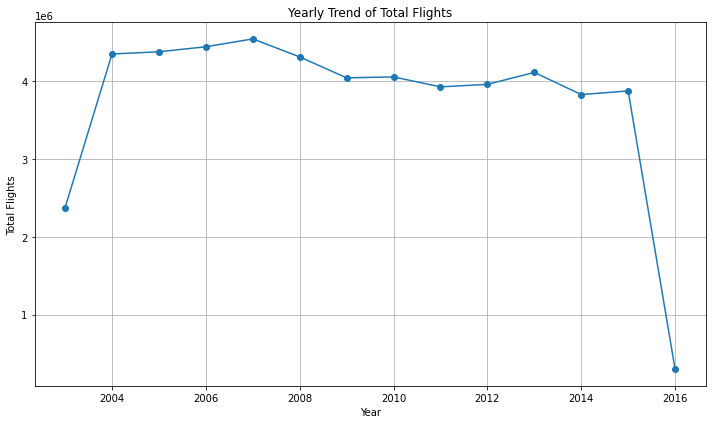

In [66]:
# Trend of total no of flights operating over different years
query5= """SELECT t.year, SUM(s.flights_total) AS Total_Flights FROM Time t
    JOIN Statistics s ON t.Label = s.time_label
    GROUP BY t.year
    ORDER BY t.year"""
flight_trends= pd.read_sql(query5,conn)
flight_trends
plt.figure(figsize=(10, 6))
plt.plot(flight_trends['year'], flight_trends['total_flights'],marker='o',linestyle='-')

plt.title('Yearly Trend of Total Flights')
plt.xlabel('Year')
plt.ylabel('Total Flights')
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
# Avg flights delayed per month
query6 = """SELECT t.Year, t.Month, AVG(s.Flights_Delayed) AS Avg_Delayed_Flights_Per_Month
FROM Time t
JOIN Statistics s ON t.Label = s.Time_Label
GROUP BY t.Year, t.Month
ORDER BY t.Year, t.Month;
"""
# df1=pd.read_sql(air,conn)
pd.read_sql(query6, conn)


,year,month,avg_delayed_flights_per_month
0,2003,6,1903.448276
1,2003,7,2198.137931
2,2003,8,2285.655172
3,2003,9,1465.965517
4,2003,10,1501.551724
...,...,...,...
147,2015,9,1408.620690
148,2015,10,1390.758621
149,2015,11,1611.034483
150,2015,12,2250.275862


In [24]:
# Airports with highest no of delays
query7 = """SELECT Airport_Code, SUM(Delays_Carrier + Delays_Late_Aircraft + Delays_National_Aviation_System + Delays_Security + Delays_Weather) AS Total_Delays
FROM Statistics
GROUP BY Airport_Code
ORDER BY Total_Delays DESC;"""
df1=pd.read_sql(query7,conn)
df1

,airport_code,total_delays
0,ATL,1052447
1,ORD,984966
2,DFW,657627
3,LAX,535263
4,DEN,506238
5,EWR,486600
6,SFO,471456
7,IAH,432613
8,LAS,380911
9,PHX,379799


Text(0, 0.5, 'Total Flight delays')

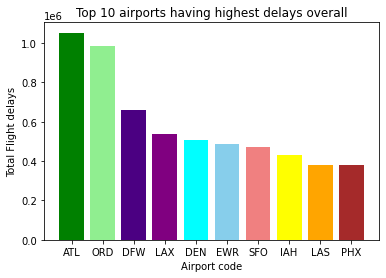

In [37]:
# Top 10 airports with delays
df1=df1[:10]
colors=["green","lightgreen","indigo","purple","cyan","skyblue","lightcoral","yellow","orange","brown"]
plt.bar(df1["airport_code"],df1["total_delays"],color=colors)
plt.title('Top 10 airports having highest delays overall')
plt.xlabel('Airport code')
plt.ylabel('Total Flight delays')

In [22]:
# Airport with the highest percentage of on-time flights
query8= """SELECT s.Airport_code, (s.flights_on_time * 100.0 / s.flights_total) AS On_Time_Percentage
FROM statistics s
ORDER BY On_Time_Percentage DESC
LIMIT 1;
"""
cursor.execute(query8)
res = cursor.fetchall()[0]
print(f"{res[0]} Airport has the highest percent with {round(float(res[1]),2)}% on-time flights")

SLC Airport has the highest percent with 93.44% on-time flights
